In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from gemmavqwhisper import GemmaWhisperForConditionalGeneration, Model
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor
import librosa
import numpy as np
import torch

torch.set_grad_enabled(False)

In [ ]:
model = Model.from_pretrained(
    'mesolitica/gemma3n-audio-encoder-whisper-decoder', torch_dtype = 'auto').train()
model.model.init_quantize_layer()

In [ ]:
_ = model.cuda()

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained(
    'mesolitica/gemma3n-audio-encoder-whisper-decoder')
tokenizer = AutoTokenizer.from_pretrained('mesolitica/gemma3n-audio-encoder-whisper-decoder')
processor = AutoProcessor.from_pretrained('openai/whisper-large-v3-turbo')

In [ ]:
from streaming import MDSWriter, LocalDataset

dataset = LocalDataset('mosaic-stt')

In [ ]:
import random

indices = set()
while len(indices) < 10000:
    i = random.randint(0, len(dataset) - 1)
    if i in indices:
        continue
    indices.add(i)

In [ ]:
from tqdm import tqdm

projections = []
for i in tqdm(indices):
    y, sr = librosa.load(dataset[i]['audio_filename'], sr = feature_extractor.sampling_rate)
    features = feature_extractor([y], return_tensors = 'pt')
    features['input_features'] = features['input_features'].cuda()
    features['input_features_mask'] = features['input_features_mask'].cuda()
    d = model.model.projection(model.model.encoder(**features)[0]).reshape(-1, 1280).cpu().numpy()
    projections.append(d)

In [ ]:
np.save('projections.npy', np.concatenate(projections))

In [3]:
projections = np.load('projections.npy')
projections.shape

(331054, 1280)

In [4]:
# done the same on second GPU
# feel free to scale up

projections_part2 = np.load('projections-part2.npy')
projections_part2.shape

(340212, 1280)

In [5]:
projections = [projections, projections_part2]
projections = np.concatenate(projections)

In [6]:
import torch.nn.functional as F
from tqdm import tqdm

batch_size = 128
n_clusters = 32768
latent_dim = 1280
device = 'cuda'

@torch.no_grad()
def kmeans_plus_plus_init(X, n_clusters, device='cuda'):
    """
    Fast KMeans++ initialization with incremental distance update.
    """
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    X = X.to(device)

    N, D = X.shape
    centroids = torch.empty(n_clusters, D, device=device)

    # Choose first centroid randomly
    i = torch.randint(0, N, (1,))
    centroids[0] = X[i]

    # Initialize closest distances for each point
    min_distances = torch.cdist(X, centroids[0:1]).squeeze(1).pow(2)  # [N]

    for k in tqdm(range(1, n_clusters)):
        probs = min_distances / min_distances.sum()
        next_idx = torch.multinomial(probs, 1)
        centroids[k] = X[next_idx]

        # Update min_distances incrementally
        dist_to_new = torch.cdist(X, centroids[k:k+1]).squeeze(1).pow(2)
        min_distances = torch.minimum(min_distances, dist_to_new)

    return centroids

In [7]:
cache_file = 'centroids++.npy'
sample = torch.randint(low = 0, high = projections.shape[0] - 1, size = (200000,))
centroids = kmeans_plus_plus_init(projections[sample], n_clusters, device=device)
np.save(cache_file, centroids.cpu().numpy())

100%|████████████████████████████████████| 32767/32767 [04:58<00:00, 109.62it/s]


In [10]:
counts = torch.zeros(n_clusters, device=device)

for i in tqdm(range(0, len(projections), batch_size)):
    hidden = torch.from_numpy(projections[i: i + batch_size]).to(device)
    
    dists = (
        hidden.pow(2).sum(1, keepdim=True)
        - 2 * torch.matmul(hidden, centroids.t())
        + centroids.pow(2).sum(1)
    )
    indices = torch.argmin(dists, dim=1)
    assignments = F.one_hot(indices, num_classes=n_clusters).float()

    cluster_counts = assignments.sum(dim=0)
    cluster_sums = assignments.T @ hidden

    cluster_means = torch.where(
        cluster_counts.unsqueeze(1) > 0,
        cluster_sums / cluster_counts.unsqueeze(1).clamp(min=1e-6),
        centroids
    )

    eta = torch.where(
        (counts + cluster_counts) > 0,
        1.0 / (counts + cluster_counts).clamp(min=1e-6),
        torch.zeros_like(counts)
    ).unsqueeze(1)

    centroids = (1 - eta) * centroids + eta * cluster_means
    counts += cluster_counts

100%|██████████████████████████████████████| 5245/5245 [00:20<00:00, 260.04it/s]


In [11]:
hidden = torch.from_numpy(projections[1000:1100]).to(device)
dists = (
    hidden.pow(2).sum(1, keepdim=True)
    - 2 * torch.matmul(hidden, centroids.t())
    + centroids.pow(2).sum(1)
)
torch.argmin(dists, dim=1)

tensor([25209, 13731, 18839, 30152,  7086, 17634, 16805, 13322,   629, 31199,
        13050, 22390, 15686, 22076, 28352, 28352, 28238, 16666, 18667, 14135,
         2906,   129, 30906, 13615, 28469,  1743, 14870, 30618,  4607,  1271,
        21603, 11867, 30893,  3833,  2062, 11593, 29125, 31931, 15508, 15371,
        10945, 13401,  6076, 12912,  8580, 20737, 18290,  2817, 14422, 24670,
        21354,   685, 24069, 17868, 25170, 32043, 16350, 17690, 24751, 30928,
         3275, 27226, 12550, 21837,  1249, 29337, 26195,  6266, 14190,    93,
        11436, 30089,  2348,  4899, 19544, 22053, 30856, 19602, 12887,  7520,
        27515,  4310, 25160, 18842, 31593, 28886,  1016,  2892,  1683, 17093,
         6813, 17274, 32104, 30782,  5399, 29664,   938, 18559, 18141, 21643],
       device='cuda:0')

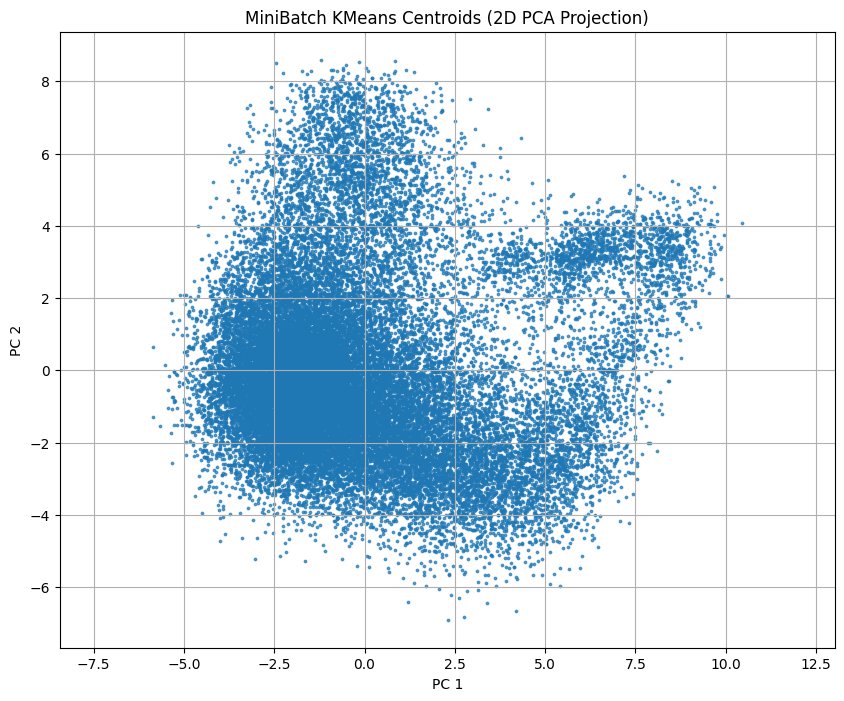

In [12]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

centroids_cpu = centroids.detach().cpu().numpy()

pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(centroids_cpu)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=3, alpha=0.7)
plt.title('MiniBatch KMeans Centroids (2D PCA Projection)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.axis('equal')
plt.show()

In [13]:
np.save('centroids.npy', centroids.cpu().numpy())